In [1]:
import sys, os
import numpy as np
sys.path.append('../src/')
import torch
from MolGraphNetwork import MolGraphNetwork
from scf_guess_tools import Backend

BASIS_PATH = "pcseg-1"
GEOMETRY_Source = "/home/etschgi1/REPOS/Masterarbeit/datasets/QM9/xyz_c7h10o2_sorted"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MGNN = MolGraphNetwork(xyz_source=GEOMETRY_Source,
                       basis=BASIS_PATH,
                       backend=Backend.PY,
                       batch_size=16,
                       hidden_dim=128,
                       train_val_test_ratio=(0.8, 0.1, 0.1), 
                       message_passing_steps=3,
                       edge_threshold_val=5,
                       message_net_layers=3,
                       message_net_dropout=0.1,
                       target="fock",
                       verbose_level=2)
MGNN.load_data(max_samples=500,
               cache_meta = {"method":"dft", "basis":None, "functional": "b3lypg", "guess": "minao", "backend": "pyscf", "cache": "/home/etschgi1/REPOS/Masterarbeit/datasets/QM9/out/c7h10o2_b3lypg_pcseg1/pyscf"})

Setting verbose level to: 2
Loading 6095 files from /home/etschgi1/REPOS/Masterarbeit/datasets/QM9/xyz_c7h10o2_sorted...
Limiting to 500 samples out of 6095 total files.


Loading files: 100%|██████████| 500/500 [00:00<00:00, 1118.48it/s]
Creating graphs: 500it [00:06, 78.30it/s]


Total samples: 500, Train: 400, Val: 50, Test: 50
Found 3 center keys (['C', 'H', 'O']) and 6 edge keys (['C_C', 'C_H', 'C_O', 'H_H', 'H_O', 'O_O']) in the training set. -> Totaling 9 unique encoder/decoder.
Normalization factors computed and applied.
Center stats: {'C': (0.15901810980978467, 0.3491067062811783), 'H': (0.376943039894104, 0.46880099786953644), 'O': (0.15833881823789506, 0.3483205718277696)}, Edge stats: {'C_C': (0.005134553565423481, 0.0889675083102608), 'C_H': (0.00834677313786791, 0.08766453453163513), 'C_O': (0.002090464134651648, 0.06415885490836759), 'H_H': (0.011921217465338906, 0.057036713807302165), 'H_O': (0.0027484030003733745, 0.04566583105516226), 'O_O': (-0.0003316036761995212, 0.016086349758749653)}
First train batch: 304 atoms, 5036 edges, 304 center blocks.
Found center block size 105 for atom type O.
Found center block size 105 for atom type C.
Found center block size 15 for atom type H.
Found edge block size 196 for edge type O_O.
Found edge block size

In [2]:
RETRAIN = True
model_name = "MGNN_pcseg1_simple"
if not RETRAIN and os.path.exists(f"/home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/{model_name}.pth"):
    MGNN.load_model(f"/home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/{model_name}.pth")
else:
    MGNN.train_model(num_epochs=1, lr=1e-3, weight_decay=1e-5, model_save_path=f"/home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/{model_name}.pth")
    MGNN.save_model(f"/home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/{model_name}.pth")

Epoch 1 [Train]: 100%|██████████| 25/25 [00:33<00:00,  1.33s/it]


Epoch 1/1 → Avg Train Loss: 171.509046


Epoch 1 [Val]: 100%|██████████| 4/4 [00:00<00:00,  9.53it/s]


Epoch 1/1 → Avg Val   Loss: 71.502289
Model checkpoint saved to /home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/MGNN_pcseg1_simple.pth


Epoch 1 [Test]: 100%|██████████| 4/4 [00:00<00:00, 10.52it/s]

Test  Loss: 72.634174
Model saved to /home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/MGNN_pcseg1_simple.pth


In [3]:
test_graphs = MGNN.get_graphs("test")

Testing on random sample with id 43


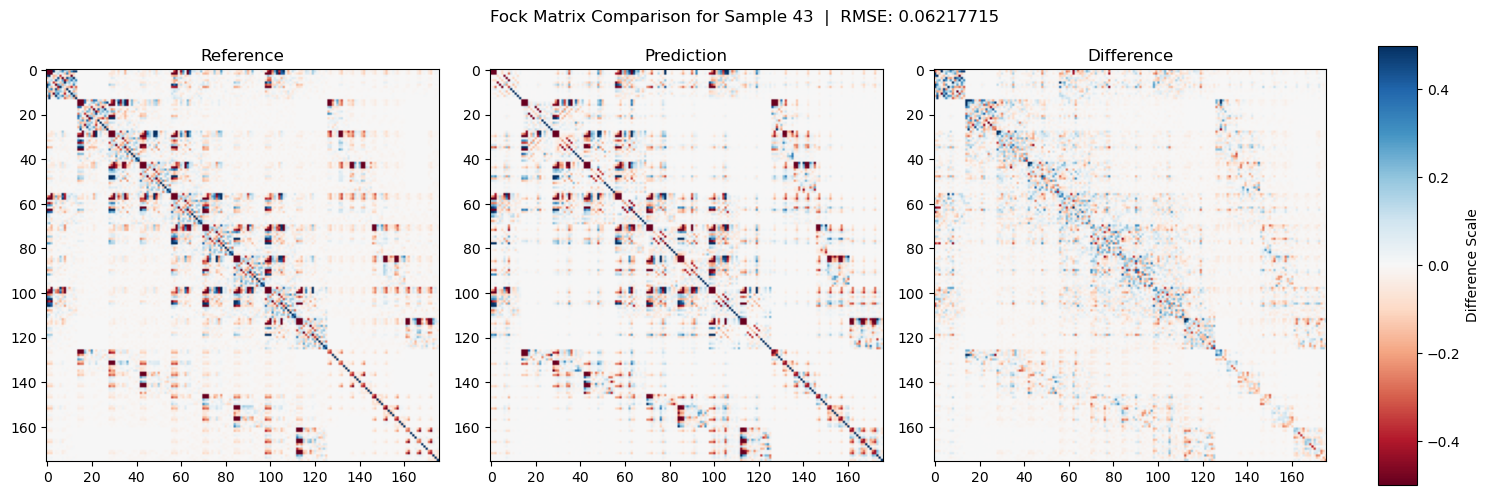

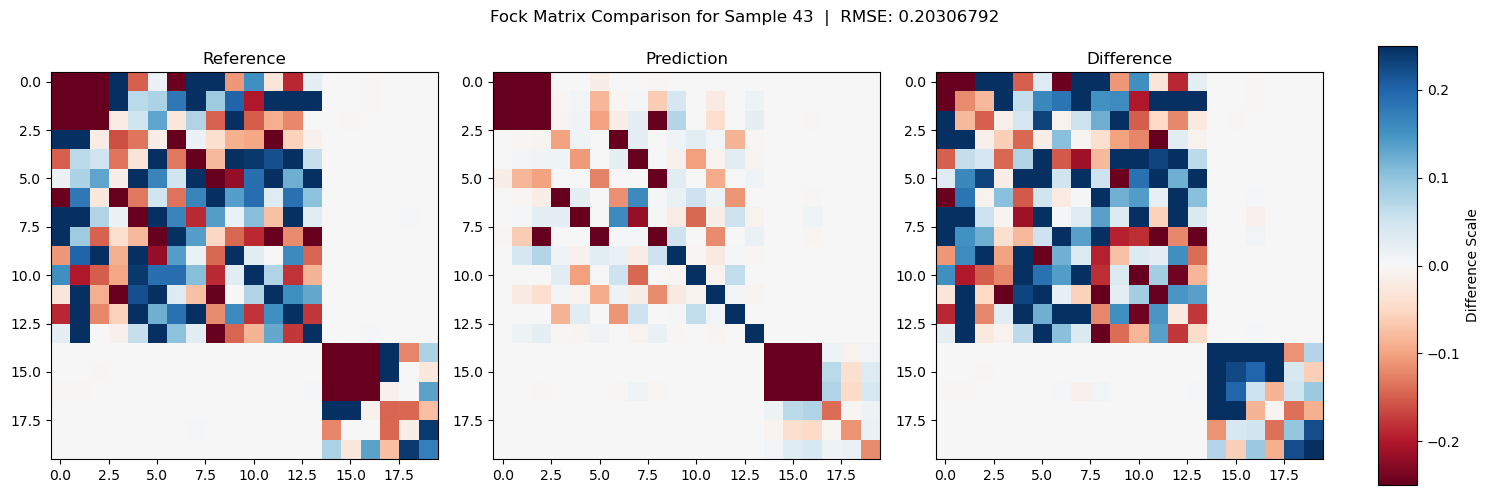

In [4]:
# aux code for testing
sys.path.append('../../')
from utils import plot_mat_comp

randsample_id = np.random.randint(0, len(test_graphs))
print(f"Testing on random sample with id {randsample_id}")
test_graph = test_graphs[randsample_id]
fock_pred = MGNN.predict([test_graph])[0]
fock_true = MGNN.get_ground_truth("test")[randsample_id]
plot_mat_comp(fock_pred, fock_true,
                     title=f"Fock Matrix Comparison for Sample {randsample_id}", vmax=0.5)
plot_mat_comp(fock_pred[:20, :20], fock_true[:20, :20],
                     title=f"Fock Matrix Comparison for Sample {randsample_id}", vmax=0.25)

Ovlp: [[1.         0.26261654 0.1722097  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.26261654 1.         0.78225493 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.1722097  0.78225493 1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.46949825 0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.46949825 0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.46949825 0.        ]
 [0.         0.         0.         0.46949825 0.         0.
  1.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.46949825 0.
  0.         1.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.46949825
  0.         0.         1.         0.        ]
 [0.         0.        

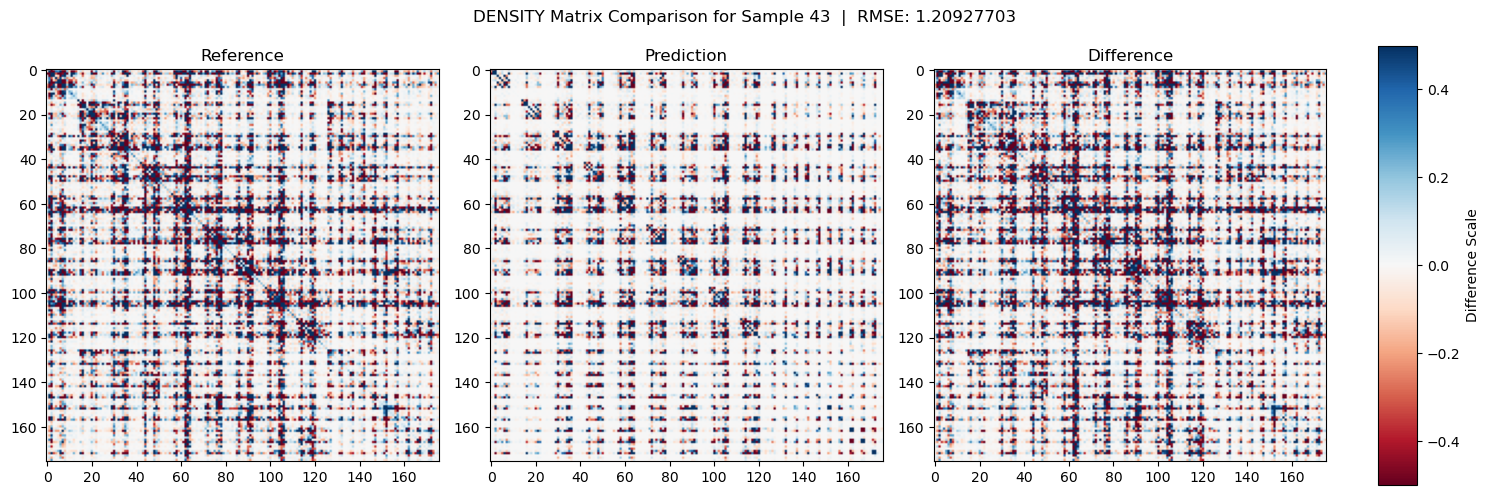

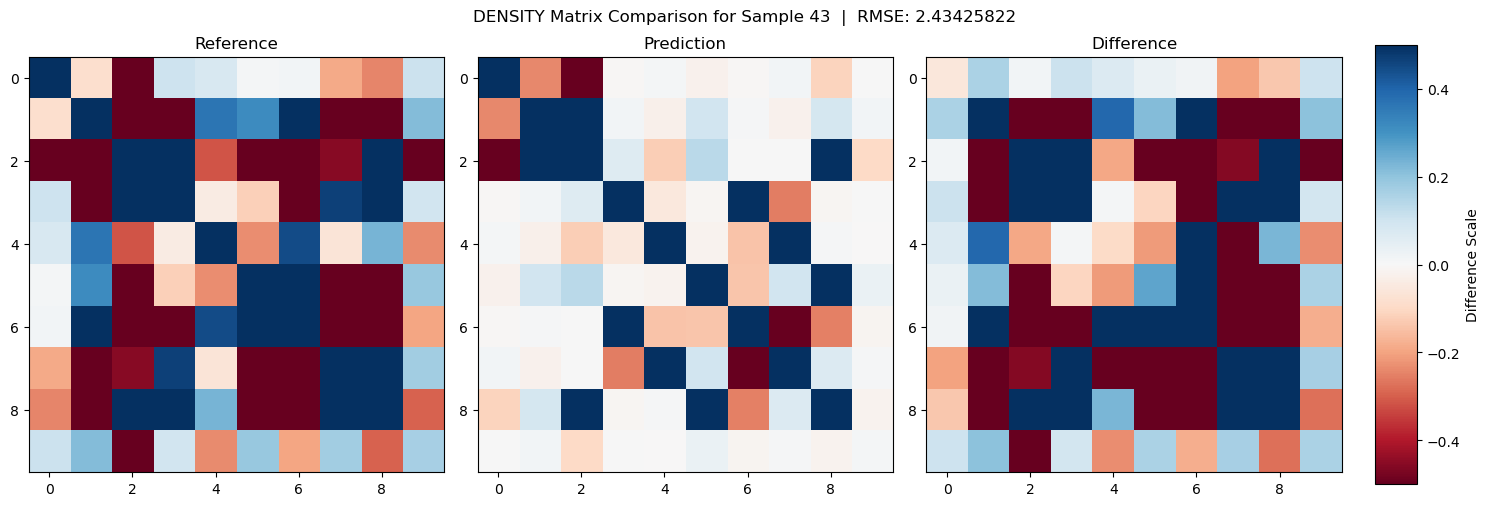

In [5]:
density_pred, density_truth = MGNN.predict([test_graph], include_target=True, transform_to_density=True)[0]
plot_mat_comp(density_pred, density_truth, 
                     title=f"DENSITY Matrix Comparison for Sample {randsample_id}", vmax=0.5)
plot_mat_comp(density_pred[:10,:10], density_truth[:10,:10], 
                     title=f"DENSITY Matrix Comparison for Sample {randsample_id}", vmax=0.5)

# Sanity check & test against ref sim!

In [6]:
from scf_guess_tools import load, calculate
from scipy.linalg import eigh
from pyscf import gto, scf

In [7]:
rand_file = MGNN.get_files("test")[randsample_id]
mol = load(rand_file, basis=BASIS_PATH, backend=Backend.PY)
wf = calculate(mol, basis=BASIS_PATH, functional="b3lypg", method="dft")
fock_recalc = wf.fock().numpy
density_recalc = wf.density().numpy

converged SCF energy = -423.012580534167


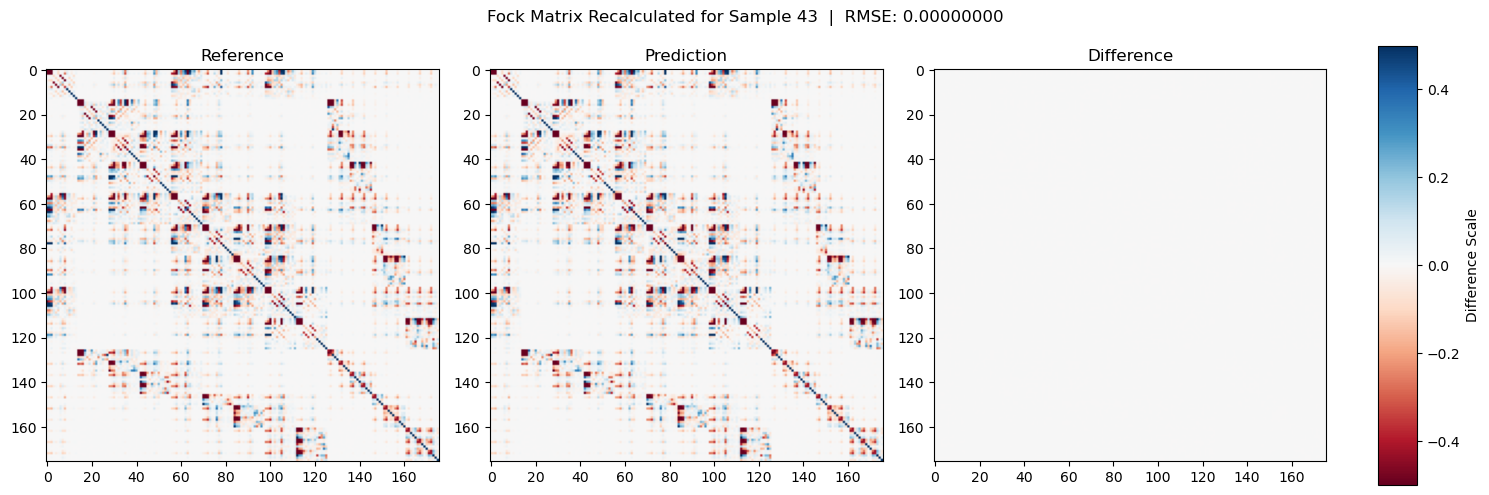

In [8]:
plot_mat_comp(fock_recalc, fock_true,
                     title=f"Fock Matrix Recalculated for Sample {randsample_id}", vmax=0.5)

ok there is no difference to the recalc vs. ground truth! Next check if we reconstruct the density correctly! 

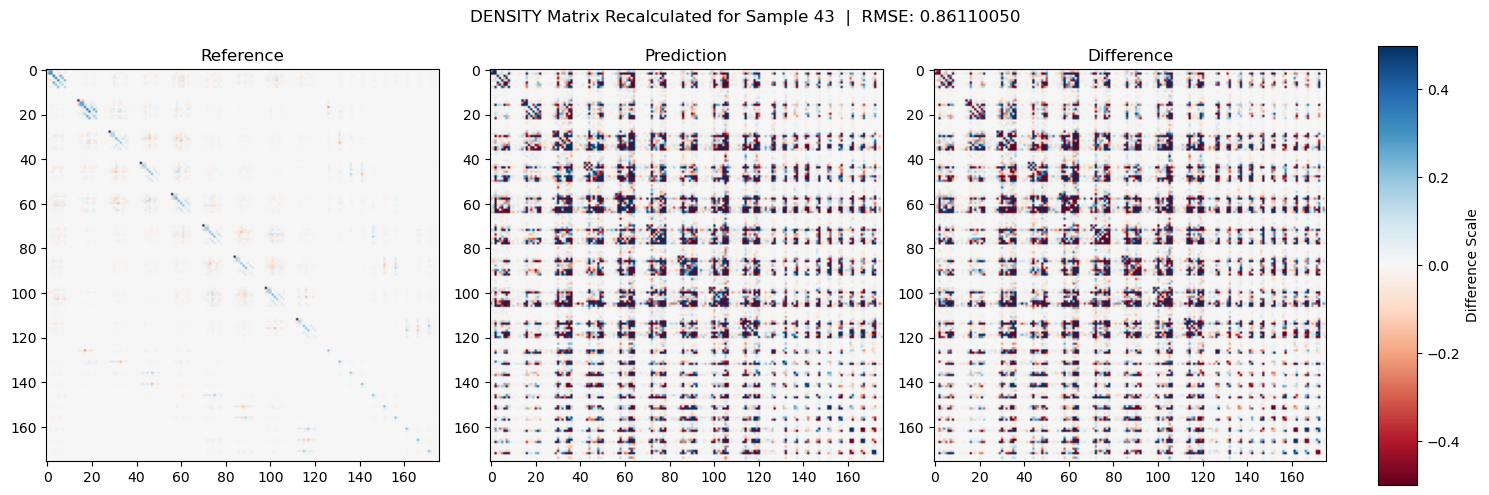

In [9]:
plot_mat_comp(density_recalc, density_truth, 
                     title=f"DENSITY Matrix Recalculated for Sample {randsample_id}", vmax=0.5)

No there is something odd going on - we fail the reconstruction! 

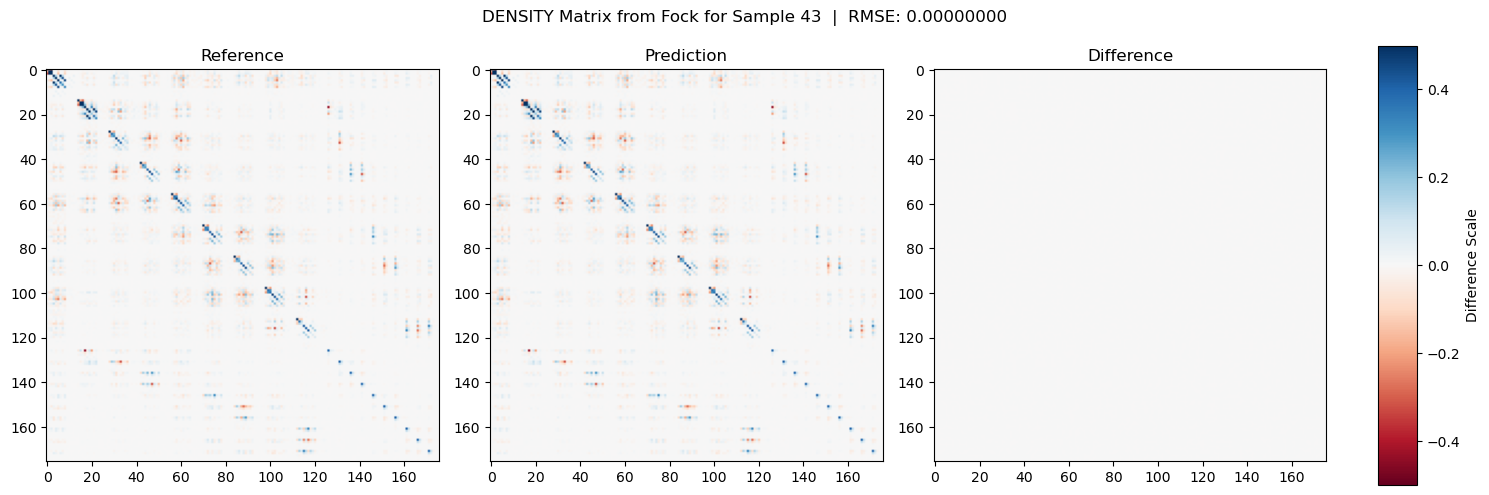

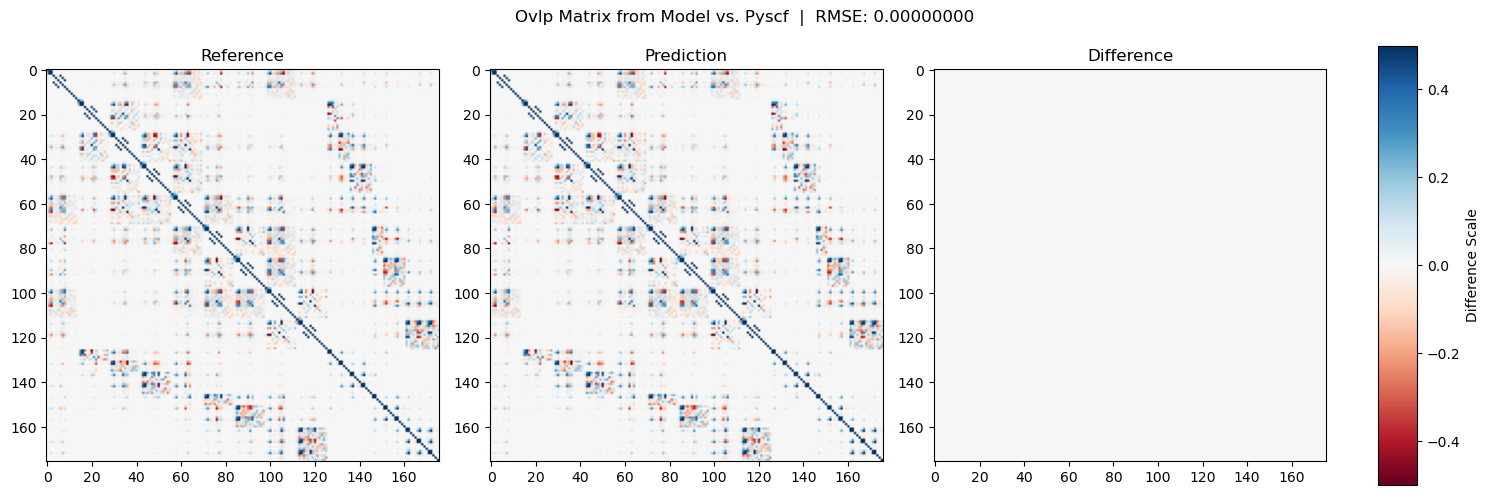

In [10]:
# manually reconstruct density from fock: 
def check_positive_definite(S, tol=1e-10):
    eigvals = np.linalg.eigvalsh(S)
    is_pd = np.all(eigvals > tol)
    return is_pd

def density_from_fock(fock, overlap, nocc):
    assert check_positive_definite(overlap)
    _, C = eigh(fock, overlap)
    C_occ = C[:, :nocc]
    density = 2 * C_occ @ C_occ.T 
    return density

moln = mol.native
nocc = moln.nelectron // 2
density_from_fock_true = density_from_fock(fock_true, moln.intor("int1e_ovlp"), nocc)
density_from_fock_recalc = density_from_fock(fock_recalc, moln.intor("int1e_ovlp"), nocc)
plot_mat_comp(density_from_fock_recalc, density_from_fock_true, 
                     title=f"DENSITY Matrix from Fock for Sample {randsample_id}", vmax=0.5)
# ovlps from model
ovlp_for_trial = MGNN.get_source_mat("test")[randsample_id]
plot_mat_comp(ovlp_for_trial, moln.intor("int1e_ovlp"), title="Ovlp Matrix from Model vs. Pyscf", vmax=0.5) # ovlp is same! 